# Bandpass filter example

This notebook demontrates how to set_up a bandwpass filter with an IQ module, and to measure its frequency response using the network analyzer of Pyrpl

All configurations are explicitely programmed in this python file, such that it's OK to start from a blanck configuration file "bandpass_example.yml"

In [1]:
# Set environment variable to use a custom configuration file location
import os
os.environ["PYRPL_USER_DIR"] = "../pyrpl_user_dir/"

In [2]:
from pyrpl import Pyrpl
p = Pyrpl("bandpass_example")

INFO:pyrpl:All your PyRPL settings will be saved to the config file
    ../pyrpl_user_dir/config\bandpass_example.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe bandpass_example" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('bandpass_example')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 10.214.1.32.


If you run this example for the first time, a window should pop-up asking you to choose the IP of the redpitaya you want to connect to. Once you have made a choice, the IP adress and the current state of pyrpl will be stored in a new config file "../pyrpl_user_dir/config/bandpass_example.yml", so you won't need to select the IP address again 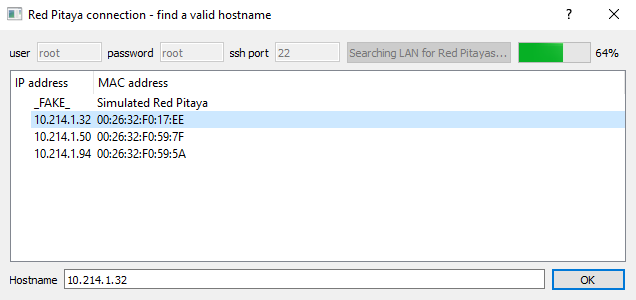

The GUI of pyrpl should now open, you can open the widgets corresponding to the different modules thanks to the top-left menu: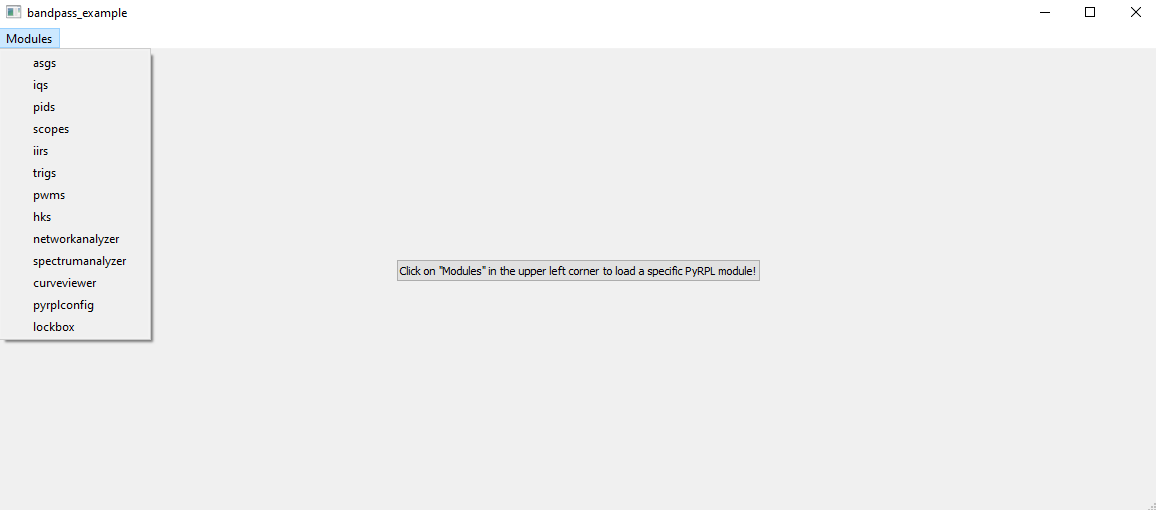

## Configure the iq module iq0 to implement a bandpass filter

In [3]:
p.rp.iq0.frequency = 15e6 # Center frequency of the filter
p.rp.iq0.bandwidth = 2300 # bandwidth of the filter (in Hz)

p.rp.iq0.quadrature_factor = 0 
p.rp.iq0.gain = 1
p.rp.iq0.amplitude = 0

p.rp.iq0.output_signal = "output_direct" # Multiplexer of the output signal uses output_direct
p.rp.iq0.input = "networkanalyzer" # Input of the network analyzer should be connected to filter output

If the GUI of the iq modules is open, iq0 should now look like the following...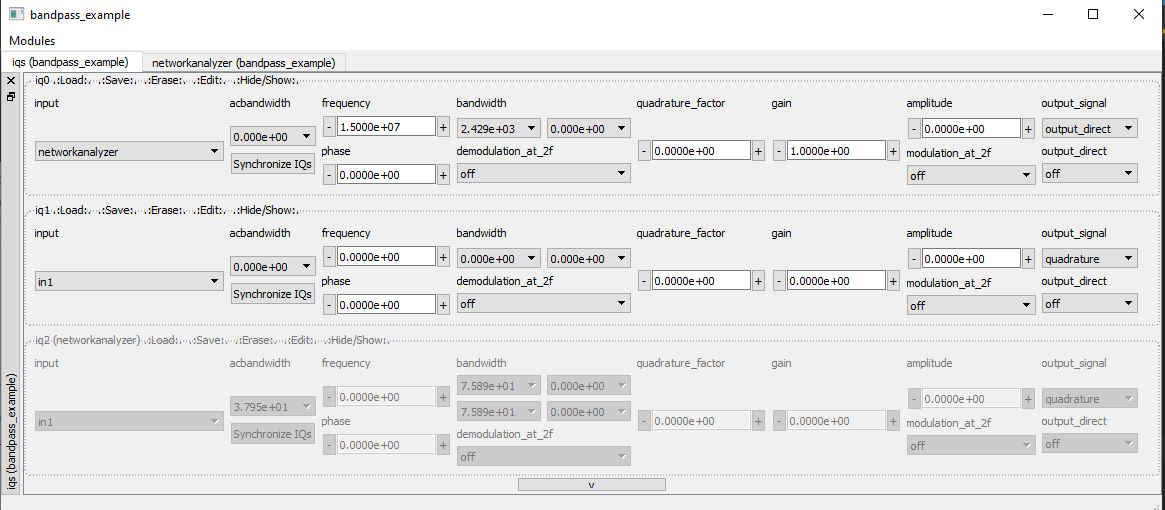

## setup the network analyzer

In [4]:
p.networkanalyzer.input = "iq0"
p.networkanalyzer.start_freq = 14.90e6
p.networkanalyzer.stop_freq = 15.10e6
p.networkanalyzer.average_per_point = 1
p.networkanalyzer.trace_average = 1
p.networkanalyzer.rbw = 100
p.networkanalyzer.logscale = True

## Launch acquisition

In [6]:
angles_iq = [0, 120, 240]
ZS = []
for angle in angles_iq: 
    p.rp.iq0.phase = angle
    zs = p.networkanalyzer.single()
    ZS.append(zs)
freqs = p.networkanalyzer.frequencies
# Use p.networkanalyzer.single_async() for non-blocking acquisition

Open the network analyzer window to monitor the on-going spectrum analyzer acquisition: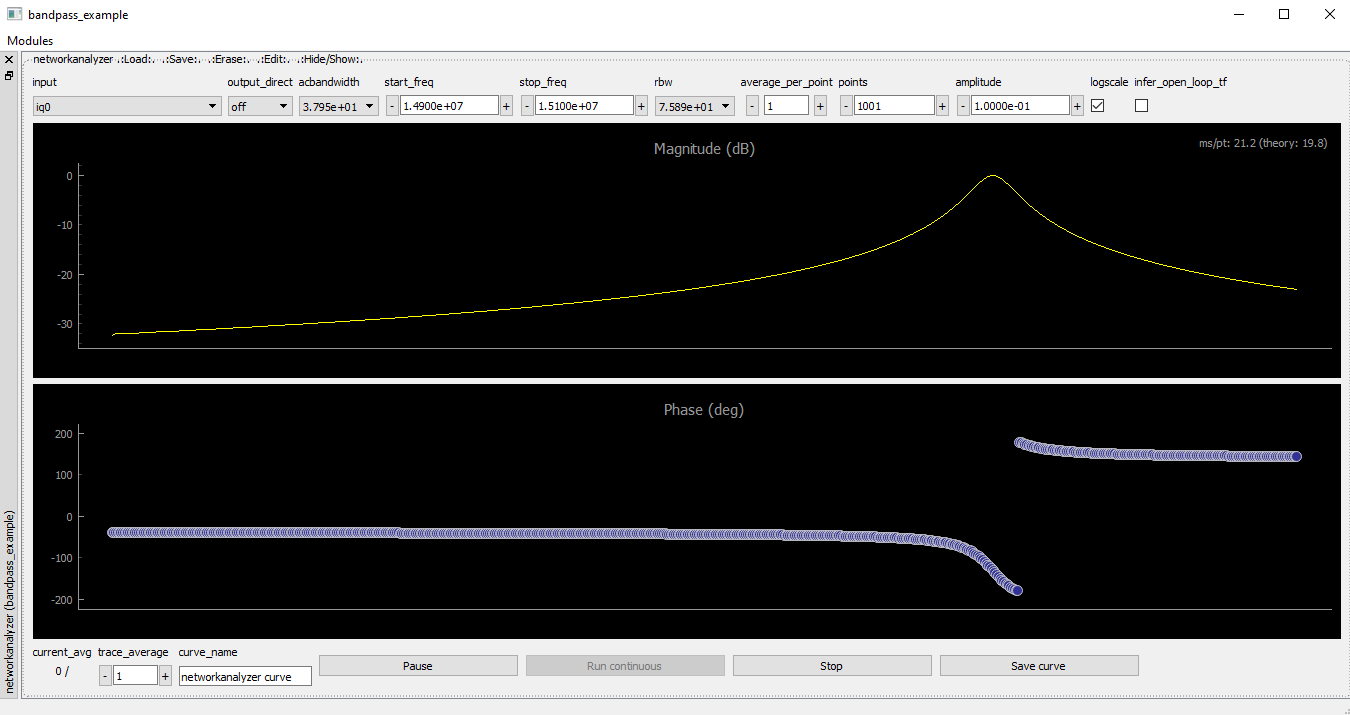

## Save the data

In [4]:
# save data 

import h5py
kwds = dict(ZS=ZS, freqs=freqs, angles_iq=angles_iq)
with h5py.File("./data/zs_data.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

## Plot the result

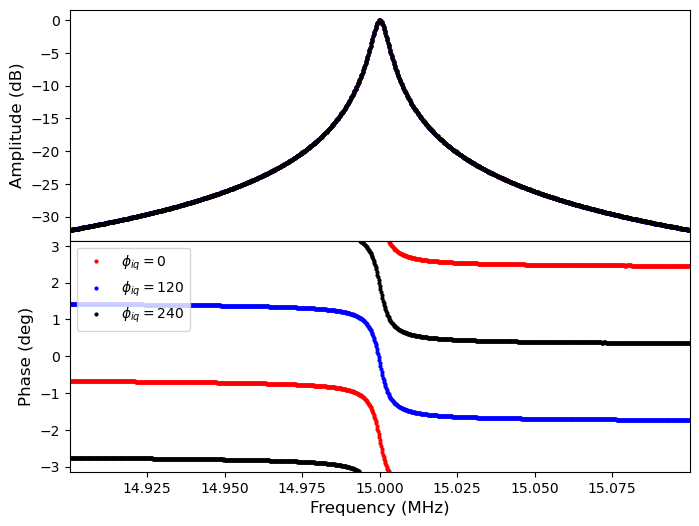

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

# load data 
kwds = {}
with h5py.File("./data/zs_data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
      
ZS, freqs, angles_iq = kwds['ZS'], kwds['freqs'], kwds['angles_iq']

ZS = np.array(ZS)
clr = ['red', 'blue', 'black']
freqs = np.real(freqs)
fig, ax = plt.subplots(2 , sharex=True, figsize=(8,6))

for i in range(len(ZS)):
    ax[0].plot(freqs/1e6, 20*np.log10(np.abs(ZS[i])),
               color=clr[i], linestyle='None', marker='o', markersize=2,
               rasterized=True)
    ax[0].set_ylabel(r'Amplitude (dB)', fontsize=12)

    ax[1].plot(freqs/1e6, np.angle(ZS[i]),
               color=clr[i], linestyle='None', marker='o', markersize=2, label=r'$\phi_{iq}=$'+str(angles_iq[i]),
               rasterized=True)
    ax[1].set_ylabel(r'Phase (deg)', fontsize=12)
    ax[1].set_xlabel(r'Frequency (MHz)', fontsize=12)
ax[0].set_xlim(min(freqs/1e6), max(freqs/1e6))
ax[1].set_ylim(-np.pi, np.pi)
    
plt.subplots_adjust(hspace=0)
plt.legend(loc='upper left')
plt.show()
fig.savefig("./figure_bandpass_filter.svg", dpi=300)